<p align="Justify"><b>Look into twitter text data to predict if the given text has positive or negative
 sentiment towards a particular brand. The dataset includes twitter text related to
 Apple and Google products with user sentiment ranked between ‘positive’,
 ‘negative’, ‘neutral’ and ‘no_idea’, sentiments. Create a simpleRNN or LSTM based
 classifiers to classify tweets into the four classes. You can avoid
 ‘emotion_in_tweet_is_directed_at’ column.</b></p>

**IMPORTING LIBRARIES**

In [63]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import html
import re
import unicodedata

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM,Embedding, LSTM,Bidirectional,SimpleRNN,Dropout, Dense
from tensorflow.keras.layers import BatchNormalization

**DATA LOADING AND INITIAL INSPECTION**

In [64]:
#Reading the dataset
twitter_data=pd.read_csv("/content/judge-1377884607_tweet_product_company.csv",encoding="ISO-8859-1")
twitter_data

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [65]:
#display first few rows
twitter_data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [66]:
#general information about the dataset
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [67]:
#checking any missing values present in the datset
twitter_data.isnull().sum()

,0
tweet_text,1
emotion_in_tweet_is_directed_at,5802
is_there_an_emotion_directed_at_a_brand_or_product,0


 **DATA CLEANING AND PREPROCESSING**

In [68]:
#The column 'emotion_in_tweet_is_directed_at' is unnecessary column.so drop it.
twitter_data = twitter_data.drop(columns='emotion_in_tweet_is_directed_at')

In [69]:
#Rename the column 'is_there_an_emotion_directed_at_a_brand_or_product' to 'user sentiment'
twitter_data = twitter_data.rename(columns={'is_there_an_emotion_directed_at_a_brand_or_product': 'user sentiment'})

In [70]:
print(twitter_data.columns)

Index(['tweet_text', 'user sentiment'], dtype='object')


In [71]:
# Filter out rows with missing tweet text to ensure only valid tweets
twitter_data = twitter_data[twitter_data['tweet_text'].notnull()]

In [72]:
#count th6e missing values
twitter_data.isnull().sum()

,0
tweet_text,0
user sentiment,0


In [73]:
#count the values in the column 'user sentiment'
twitter_data['user sentiment'].value_counts()

,count
user sentiment,
No emotion toward brand or product,5388
Positive emotion,2978
Negative emotion,570
I can't tell,156


In [74]:
# Map user sentiment to standard classes
sentiment_map = {
    'No emotion toward brand or product': 'No_idea',
    'Positive emotion': 'Positive',
    'Negative emotion': 'Negative',
    "I can't tell": 'Neutral'
}
twitter_data['user sentiment'] = twitter_data['user sentiment'].map(sentiment_map)

/tmp/ipython-input-74-2837204848.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter_data['user sentiment'] = twitter_data['user sentiment'].map(sentiment_map)


In [75]:
# Remove any remaining NaNs
twitter_data = twitter_data[twitter_data['user sentiment'].notnull()]

In [76]:
#count the values in the column 'user sentiment' after mapping
twitter_data['user sentiment'].value_counts()

,count
user sentiment,
No_idea,5388
Positive,2978
Negative,570
Neutral,156


In [77]:
#checking out the negative emotion from dataset
twitter_data[twitter_data['user sentiment']=='Negative'].head(10)

,tweet_text,user sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative
3,@sxsw I hope this year's festival isn't as cra...,Negative
17,I just noticed DST is coming this weekend. How...,Negative
38,@mention - False Alarm: Google Circles Not Co...,Negative
64,Again? RT @mention Line at the Apple store is ...,Negative
67,attending @mention iPad design headaches #sxsw...,Negative
68,Boooo! RT @mention Flipboard is developing an ...,Negative
92,What !?!? @mention #SXSW does not provide iPh...,Negative
103,Know that &quot;dataviz&quot; translates to &q...,Negative
170,Seriously #sxsw? Did you do any testing on the...,Negative


In [78]:
#checking out the positive emotion from dataset
twitter_data[twitter_data['user sentiment']=='Positive'].head(10)

,tweet_text,user sentiment
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive
7,"#SXSW is just starting, #CTIA is around the co...",Positive
8,Beautifully smart and simple idea RT @madebyma...,Positive
9,Counting down the days to #sxsw plus strong Ca...,Positive
10,Excited to meet the @samsungmobileus at #sxsw ...,Positive
11,Find &amp; Start Impromptu Parties at #SXSW Wi...,Positive
12,"Foursquare ups the game, just in time for #SXS...",Positive
13,Gotta love this #SXSW Google Calendar featurin...,Positive


In [79]:
#checking out the neutral emotion from dataset
twitter_data[twitter_data['user sentiment']=='Neutral'].head(10)

,tweet_text,user sentiment
90,Thanks to @mention for publishing the news of ...,Neutral
102,ÛÏ@mention &quot;Apple has opened a pop-up st...,Neutral
237,Just what America needs. RT @mention Google to...,Neutral
341,The queue at the Apple Store in Austin is FOUR...,Neutral
368,Hope it's better than wave RT @mention Buzz is...,Neutral
413,SYD #SXSW crew your iPhone extra juice pods ha...,Neutral
441,Why Barry Diller thinks iPad only content is n...,Neutral
488,Gave into extreme temptation at #SXSW and boug...,Neutral
640,Catch 22Û_ I mean iPad 2 at #SXSW : {link},Neutral
705,Forgot my iPhone for #sxsw. Android only. Knif...,Neutral


In [80]:
#checking out the no_idea emotion from dataset
twitter_data[twitter_data['user sentiment']=='No_idea'].head(10)

,tweet_text,user sentiment
5,@teachntech00 New iPad Apps For #SpeechTherapy...,No_idea
16,Holler Gram for iPad on the iTunes App Store -...,No_idea
32,"Attn: All #SXSW frineds, @mention Register fo...",No_idea
33,Anyone at #sxsw want to sell their old iPad?,No_idea
34,Anyone at #SXSW who bought the new iPad want ...,No_idea
35,At #sxsw. Oooh. RT @mention Google to Launch ...,No_idea
37,SPIN Play - a new concept in music discovery f...,No_idea
39,VatorNews - Google And Apple Force Print Media...,No_idea
41,HootSuite - HootSuite Mobile for #SXSW ~ Updat...,No_idea
42,Hey #SXSW - How long do you think it takes us ...,No_idea


/tmp/ipython-input-81-1634157832.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=twitter_data, x='user sentiment', palette='Set2')


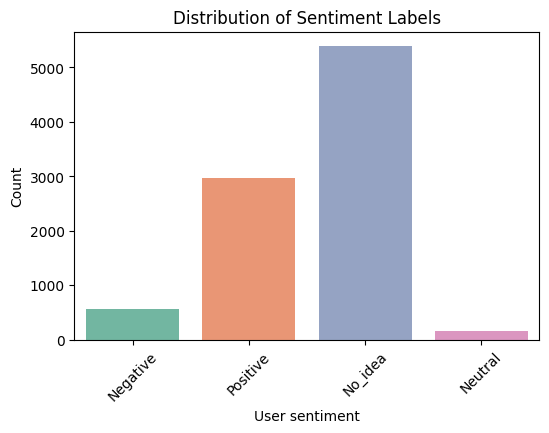

In [81]:
#Count plot for the column 'user sentiment'
plt.figure(figsize=(6,4))
sns.countplot(data=twitter_data, x='user sentiment', palette='Set2')

plt.title('Distribution of Sentiment Labels')
plt.xlabel('User sentiment')
plt.ylabel('Count')

plt.xticks(rotation=45)
plt.show()


**TEXT PREPROCESSING**

In [82]:
# Download stopwords
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [83]:
negation_words = {"not", "no", "nor", "never"}
stop_words = set(stopwords.words('english')) - negation_words
lemmatizer = WordNetLemmatizer()

In [84]:
def preprocess_text(text):
    text = str(text).lower() # Lowercase
    text = re.sub(r'@\w+', '', text) # Remove mentions
    text = html.unescape(text)  # Decode HTML entities
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8') # Remove non-ASCII

    words = text.split() # Tokenize manually by splitting on spaces
    # Remove URLs and mentions/hashtags (check if word starts with  #, or contains 'http','www','{','}')
    words = [word for word in words if not (
        word.startswith('#') or 'http' in word or 'www' in word or
        'link' in word or '{' in word or '}' in word)]

    # Remove punctuation and numbers
    clean = []
    for word in words:
        word_alpha = ''.join(char for char in word if char.isalpha()) #keep only alpha numeric characters
        if word_alpha and word_alpha not in stop_words:
            clean.append(lemmatizer.lemmatize(word_alpha))
    # Join words back into a string
    return ' '.join(clean)

**APPLY PREPROCESSING**

In [85]:
# Clean the tweet_text column
twitter_data['preprocessed'] = twitter_data['tweet_text'].apply(preprocess_text)

In [86]:
# Remove empty or whitespace-only rows
twitter_data = twitter_data[twitter_data['preprocessed'].str.strip() != '']

**LABEL ENCODING**

In [87]:
# Encode user sentiment labels to integers
twitter_data = twitter_data.copy()  # ensure it's a copy, not a view

label_encoder = LabelEncoder()
twitter_data.loc[:, 'label'] = label_encoder.fit_transform(twitter_data['user sentiment'])

num_classes = len(label_encoder.classes_)


In [88]:
print("Label classes:", list(label_encoder.classes_))

Label classes: ['Negative', 'Neutral', 'No_idea', 'Positive']


In [89]:
# After fitting label encoder
print("Label mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{i} → {label}")

Label mapping:
0 → Negative
1 → Neutral
2 → No_idea
3 → Positive


**DEFINE X AND Y**

In [90]:
X_text = twitter_data['preprocessed']
y = twitter_data['label']

**SPLITTING DATA**

In [91]:
X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42, stratify=y)

In [92]:
#printing Train labels and Test labela
print("Train labels:", np.unique(y_train))
print("Test labels :", np.unique(y_test))

Train labels: [0 1 2 3]
Test labels : [0 1 2 3]


In [93]:
#print the shape of the X_train_text
print(X_train_text.shape)

(7267,)


In [94]:
#print the shape of the X_test_text
print(X_test_text.shape)

(1817,)


**TOKENIZATION**

In [95]:
# Combine all preprocessed tweets into one big string and split into words
all_words = ' '.join(twitter_data['preprocessed']).split()
unique_words = set(all_words)

# Print number of unique words for counting5 num_words
print("Number of unique words:", len(unique_words))

# Calculate tweet lengths
tweet_lengths = twitter_data['preprocessed'].apply(lambda x: len(x.split()))

# Print max tweet length
print("Max tweet length:", tweet_lengths.max())

Number of unique words: 8019
Max tweet length: 23


In [96]:
'''Here, the number of unique words is 8019, but we round it up to 10,000 when setting num_words in the tokenizer and
Max tweet length 23, but we round it up to 50 when setting maxlen in the pad_sequences'''
num_words=10000
max_len=30

In [97]:
#tokenization
tokenizer = Tokenizer(num_words=num_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_text)

**PADDING SEQUENCES**

In [98]:
#padding
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train_text), maxlen=max_len)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test_text), maxlen=max_len)

In [99]:
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

X_train shape: (7267, 30), X_test shape: (1817, 30)


**HANDLING CLASS IMBALANCE**

In [100]:
# Handle class imbalance
class_weights_array = compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=y_train)

In [101]:
class_weights = dict(enumerate(class_weights_array))
print("Class weights:", class_weights)

Class weights: {0: np.float64(3.9841008771929824), 1: np.float64(14.534), 2: np.float64(0.42210734200743494), 3: np.float64(0.7626994122586063)}


**BUILD THE DEEP LEARNING MODELS**

SIMPLE RNN:

In [102]:
#Build RNN model
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=10000, output_dim=128, input_length=max_len)),
model_rnn.add(SimpleRNN(64, return_sequences=True)),
model_rnn.add(Dropout(0.5)),
model_rnn.add(SimpleRNN(32)),
model_rnn.add(Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [103]:
#compile the model
model_rnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [104]:
#Train Model with EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [105]:
#fit the model
history_rnn = model_rnn.fit(X_train, y_train,validation_split=0.1,epochs=15,batch_size=32,class_weight=class_weights,callbacks=[early_stop])

Epoch 1/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.2365 - loss: 1.5001 - val_accuracy: 0.5447 - val_loss: 1.2452
Epoch 2/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5595 - loss: 1.0573 - val_accuracy: 0.5309 - val_loss: 1.1144
Epoch 3/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7945 - loss: 0.4625 - val_accuracy: 0.5021 - val_loss: 1.2349
Epoch 4/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8640 - loss: 0.2755 - val_accuracy: 0.5750 - val_loss: 1.1315


In [106]:
# Evaluate the model
loss_rnn, acc_rnn = model_rnn.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {acc_rnn:.4f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5044 - loss: 1.1386

Test Accuracy: 0.5146


LSTM MODEL:

In [107]:
#Building LSTM model
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=10000, output_dim=128, input_length=max_len))
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(32))
model_lstm.add(Dense(num_classes, activation='softmax'))

In [108]:
#compile the model
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [109]:
#fit the model
history_lstm = model_lstm.fit(X_train, y_train,validation_split=0.1,epochs=15,batch_size=32,class_weight=class_weights,callbacks=[early_stop])

Epoch 1/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4137 - loss: 1.4155 - val_accuracy: 0.6052 - val_loss: 1.0589
Epoch 2/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5939 - loss: 1.0433 - val_accuracy: 0.4856 - val_loss: 1.1021
Epoch 3/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7288 - loss: 0.5909 - val_accuracy: 0.5516 - val_loss: 1.1004


In [110]:
# Evaluate the model
loss_lstm, acc_lstm = model_lstm.evaluate(X_test, y_test)
print(f"\nLSTM Test Accuracy: {acc_lstm:.4f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5865 - loss: 1.0808

LSTM Test Accuracy: 0.5850


BIDIRECTIONAL LSTM:

In [111]:
#Build the bidirectional LSTM model
model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(input_dim=10000, output_dim=128, input_length=max_len))
model_bi_lstm.add(Bidirectional(LSTM(64, return_sequences=True)))
model_bi_lstm.add(Dropout(0.5))
model_bi_lstm.add(Bidirectional(LSTM(32)))
model_bi_lstm.add(Dense(num_classes, activation='softmax'))

In [112]:
#compile the model
model_bi_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [113]:
#fit the model
history_bi_lstm = model_bi_lstm.fit(X_train, y_train,validation_split=0.1,epochs=15,batch_size=32,class_weight=class_weights,callbacks=[early_stop])

Epoch 1/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.1647 - loss: 1.4222 - val_accuracy: 0.5048 - val_loss: 1.2176
Epoch 2/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5578 - loss: 1.0869 - val_accuracy: 0.5021 - val_loss: 1.1732
Epoch 3/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7208 - loss: 0.6290 - val_accuracy: 0.5461 - val_loss: 1.1895
Epoch 4/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7912 - loss: 0.4093 - val_accuracy: 0.6039 - val_loss: 1.1026
Epoch 5/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8462 - loss: 0.2917 - val_accuracy: 0.5763 - val_loss: 1.1378
Epoch 6/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8646 - loss: 0.2394 - val_accuracy: 0.5928 - val_loss: 1.1234


In [114]:
# Evaluate the model
loss_bi_lstm, acc_bi_lstm = model_bi_lstm.evaluate(X_test, y_test)
print(f"\nLSTM Test Accuracy: {acc_bi_lstm:.4f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5898 - loss: 1.1335

LSTM Test Accuracy: 0.6010


In [115]:
#compare accuracy
print(f"\nFinal Accuracy Comparison:")
print(f"RNN  → {acc_rnn:.4f}")
print(f"LSTM → {acc_lstm:.4f}")
print(f"BIDIRECTIONAL LSTM → {acc_bi_lstm:.4f}")


Final Accuracy Comparison:
RNN  → 0.5146
LSTM → 0.5850
BIDIRECTIONAL LSTM → 0.6010


**PREDICTION**:**We get greater accuracy in Bidirectional LSTM moel.So choose Bidirectional LSTM model for prediction**

**PREDICT SENTIMENT**

In [116]:
def predict_sentiment(tweet, tokenizer, model, label_encoder, max_len=50):
    # Clean the input tweet
    tweet_cleaned = preprocess_text(tweet)

    # Convert to sequence and pad
    sequence = tokenizer.texts_to_sequences([tweet_cleaned])
    padded = pad_sequences(sequence, maxlen=50)

    # Predict
    prediction = model.predict(padded)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Decode predicted class to label
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]

    return predicted_label

**PREDICTION RESULT:NEGATIVE**

In [117]:
#Access the tweet text for prediction(e.g:Negative)
row = twitter_data[twitter_data['user sentiment'] == 'Negative'].iloc[68]
# Print original,preprocessed tweet,and user sentiment
print("Original Tweet:", row['tweet_text'])
print("Preprocessed Tweet:", row['preprocessed'])
print("Sentiment Label:", row['user sentiment'])

Original Tweet: .@mention Problem with Google Living Stories was the process of creating content didn't change - was just an interface. #hacknews #SXSW
Preprocessed Tweet: problem google living story process creating content didnt change interface
Sentiment Label: Negative


In [118]:
#Test prediction
new_tweet = "problem google living story process creating content didnt change interface"
predicted = predict_sentiment(new_tweet, tokenizer,model_bi_lstm, label_encoder)
print(f"\nTweet: \"{new_tweet}\"\nPredicted Sentiment: {predicted} 😞")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step

Tweet: "problem google living story process creating content didnt change interface"
Predicted Sentiment: Negative 😞


**PREDICTION RESULT:POSITIVE**

In [119]:
#Access the tweet text for prediction(e.g:Positive)
row = twitter_data[twitter_data['user sentiment'] == 'Positive'].iloc[25]

# Print original,preprocessed tweet,and user sentiment
print("Original Tweet:", row['tweet_text'])
print("Preprocessed Tweet:", row['preprocessed'])
print("Sentiment Label:", row['user sentiment'])

Original Tweet: You must have this app for your iPad if you are going to #SXSW http://itunes.apple.com/us/app/holler-gram/id420666439?mt=8 #hollergram
Preprocessed Tweet: must app ipad going
Sentiment Label: Positive


In [120]:
#Test prediction
new_tweet = "must app ipad going"
predicted = predict_sentiment(new_tweet, tokenizer, model_bi_lstm, label_encoder)
print(f"\nTweet: \"{new_tweet}\"\nPredicted Sentiment: {predicted} 😊")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Tweet: "must app ipad going"
Predicted Sentiment: Positive 😊


**PREDICTION RESULT:NEUTRAL**

In [121]:
#Access the tweet text for prediction(e.g:Neutral)
row = twitter_data[twitter_data['user sentiment'] =='Neutral'].iloc[88]

# Print original,preprocessed tweet,and user sentiment
print("Original Tweet:", row['tweet_text'])
print("Preprocessed Tweet:", row['preprocessed'])
print("Sentiment Label:", row['user sentiment'])

Original Tweet: The hive of innovation but yet every booth at the #SXSW trade show had the exact same promotional idea: iPad 2 Raffle!
Preprocessed Tweet: hive innovation yet every booth trade show exact promotional idea ipad raffle
Sentiment Label: Neutral


In [122]:
#Test prediction
new_tweet = "hive innovation yet every booth trade show exact promotional idea ipad raffle"
predicted = predict_sentiment(new_tweet, tokenizer, model_bi_lstm, label_encoder)
print(f"\nTweet: \"{new_tweet}\"\nPredicted Sentiment: {predicted} 😐")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Tweet: "hive innovation yet every booth trade show exact promotional idea ipad raffle"
Predicted Sentiment: Neutral 😐


**PREDICTION RESULT:No_idea**

In [123]:
#Access the tweet text for prediction(e.g:No_idea)
row = twitter_data[twitter_data['user sentiment']== 'No_idea'].iloc[33]


# Print original,preprocessed tweet,and user sentiment
print("Original Tweet:", row['tweet_text'])
print("Preprocessed Tweet:", row['preprocessed'])
print("Sentiment Label:", row['user sentiment'])

Original Tweet: Stay tune @mention showcase #H4ckers {link} #SXSW
Preprocessed Tweet: stay tune showcase
Sentiment Label: No_idea


In [124]:
#Test prediction
new_tweet = " stay tune showcase"
predicted = predict_sentiment(new_tweet, tokenizer, model_bi_lstm, label_encoder)
print(f"\nTweet: \"{new_tweet}\"\nPredicted Sentiment: {predicted}❓")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Tweet: " stay tune showcase"
Predicted Sentiment: No_idea❓
